# Chapter 3: Labeling Financial Data for Machine Learning

This notebook demonstrates the labeling techniques from **Advances in Financial Machine Learning** by Marcos López de Prado.

## Why Labeling Matters

Supervised learning algorithms require that feature rows (X) are associated with labels or values (y). In finance, how we label our data has profound implications for:

1. **What the model learns** - Are we predicting direction, magnitude, or whether to trade at all?
2. **Realistic trading** - Do our labels account for stop-losses and holding periods?
3. **Class balance** - Are our labels reasonably distributed for effective learning?

## Table of Contents

1. [The Problem with Fixed-Time Horizon Labeling](#1.-The-Problem-with-Fixed-Time-Horizon-Labeling)
2. [Dynamic Volatility Thresholds](#2.-Dynamic-Volatility-Thresholds)
3. [The Triple-Barrier Method](#3.-The-Triple-Barrier-Method)
4. [Learning Side and Size](#4.-Learning-Side-and-Size)
5. [Meta-Labeling](#5.-Meta-Labeling)
6. [Handling Imbalanced Labels](#6.-Handling-Imbalanced-Labels)

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent.parent))

# Import our labeling module
from afml.labeling import (
    get_daily_volatility,
    apply_triple_barrier,
    get_events,
    add_vertical_barrier,
    get_labels,
    get_labels_side_and_size,
    drop_rare_labels,
)

# Plotting settings
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        pass  # Use default style
plt.rcParams['figure.figsize'] = (12, 6)

# Reproducibility
np.random.seed(42)

## Generate Synthetic Price Data

For demonstration purposes, we'll create synthetic price data that mimics real market behavior with trends, mean-reversion, and varying volatility regimes.

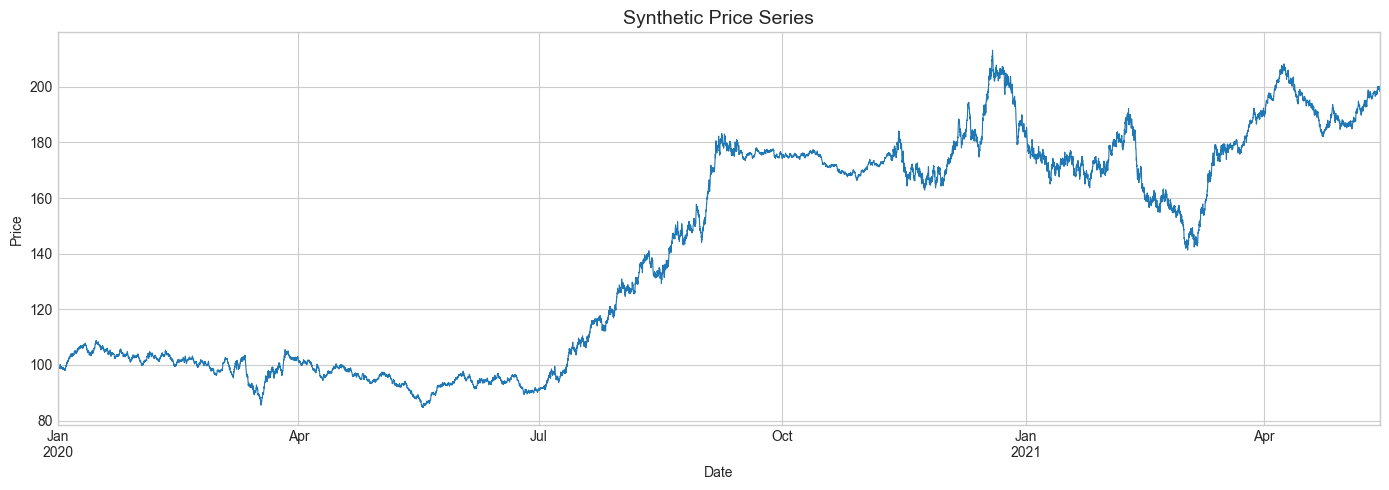

Price data shape: (12000,)
Date range: 2020-01-01 00:00:00 to 2021-05-14 23:00:00


In [2]:
def generate_synthetic_prices(
    n_days: int = 500,
    initial_price: float = 100.0,
    annual_volatility: float = 0.20,
    annual_drift: float = 0.05,
    freq: str = 'h',  # hourly data
) -> pd.Series:
    """
    Generate synthetic price data using geometric Brownian motion
    with regime-switching volatility.
    """
    # Create datetime index
    if freq == 'h':
        periods = n_days * 24
    else:
        periods = n_days
    
    index = pd.date_range(
        start='2020-01-01',
        periods=periods,
        freq=freq,
    )
    
    # Daily parameters
    dt = 1 / 252 if freq == 'D' else 1 / (252 * 24)
    daily_vol = annual_volatility * np.sqrt(dt)
    daily_drift = annual_drift * dt
    
    # Generate returns with regime-switching volatility
    returns = np.zeros(periods)
    vol_regime = 1.0
    
    for i in range(periods):
        # Occasionally switch volatility regime
        if np.random.random() < 0.001:
            vol_regime = np.random.choice([0.5, 1.0, 2.0])
        
        returns[i] = daily_drift + daily_vol * vol_regime * np.random.randn()
    
    # Convert to prices
    prices = initial_price * np.exp(np.cumsum(returns))
    
    return pd.Series(prices, index=index, name='close')


# Generate price data
close_prices = generate_synthetic_prices(n_days=500)

# Plot the price series
fig, ax = plt.subplots(figsize=(14, 5))
close_prices.plot(ax=ax, linewidth=0.8)
ax.set_title('Synthetic Price Series', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.tight_layout()
plt.show()

print(f"Price data shape: {close_prices.shape}")
print(f"Date range: {close_prices.index[0]} to {close_prices.index[-1]}")

---

## 1. The Problem with Fixed-Time Horizon Labeling

The traditional approach in academic ML papers labels observations using a **fixed-time horizon method**:

$$
y_i = \begin{cases}
-1 & \text{if } r_{t_{i,0}, t_{i,0}+h} < -\tau \\
0 & \text{if } |r_{t_{i,0}, t_{i,0}+h}| \leq \tau \\
1 & \text{if } r_{t_{i,0}, t_{i,0}+h} > \tau
\end{cases}
$$

Where:
- $\tau$ is a fixed threshold
- $h$ is a fixed time horizon
- $r$ is the return over horizon $h$

### Problems with this approach:

1. **Same threshold regardless of volatility**: A 1% move means very different things during calm vs. volatile markets
2. **Ignores the price path**: A strategy might have been stopped out before reaching the horizon
3. **Time bars have poor statistical properties**: Volume and volatility vary significantly across time

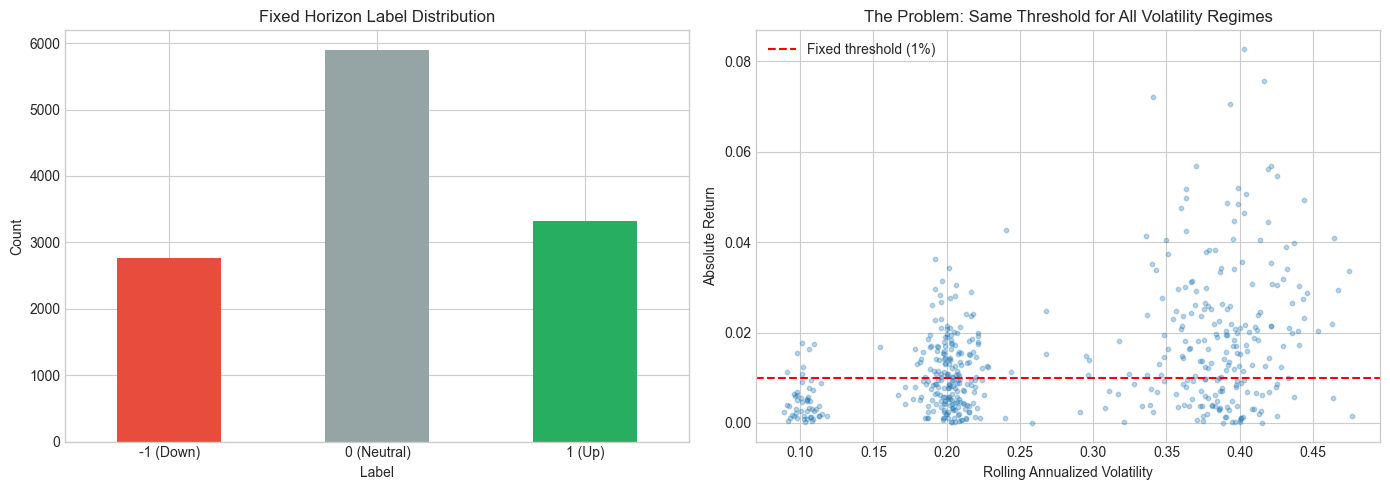


Label distribution:
bin
-1    0.230795
 0    0.492401
 1    0.276804
Name: proportion, dtype: float64


In [3]:
def fixed_horizon_labels(
    close: pd.Series,
    horizon: int = 24,  # hours
    threshold: float = 0.01,  # 1%
) -> pd.DataFrame:
    """
    Traditional fixed-time horizon labeling (NOT recommended).
    
    This is shown for comparison purposes only.
    """
    # Calculate returns over fixed horizon
    future_returns = close.shift(-horizon) / close - 1
    
    # Assign labels based on fixed threshold
    labels = pd.DataFrame(index=close.index)
    labels['ret'] = future_returns
    labels['bin'] = 0
    labels.loc[future_returns > threshold, 'bin'] = 1
    labels.loc[future_returns < -threshold, 'bin'] = -1
    
    return labels.dropna()


# Apply fixed horizon labeling
fixed_labels = fixed_horizon_labels(close_prices, horizon=24, threshold=0.01)

# Show label distribution
label_counts = fixed_labels['bin'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Label distribution
colors = ['#e74c3c', '#95a5a6', '#27ae60']
label_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Fixed Horizon Label Distribution', fontsize=12)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['-1 (Down)', '0 (Neutral)', '1 (Up)'], rotation=0)

# The problem: returns vs volatility
# Compute rolling volatility and align with fixed_labels
rolling_vol = close_prices.pct_change().rolling(24*5).std() * np.sqrt(24*252)

# Create aligned data for scatter plot
common_idx = fixed_labels.index.intersection(rolling_vol.dropna().index)
vol_aligned = rolling_vol.loc[common_idx].iloc[::24]
ret_aligned = fixed_labels.loc[common_idx, 'ret'].iloc[::24].abs()

# Ensure same length
min_len = min(len(vol_aligned), len(ret_aligned))
axes[1].scatter(vol_aligned.values[:min_len], ret_aligned.values[:min_len], 
                alpha=0.3, s=10)
axes[1].axhline(y=0.01, color='red', linestyle='--', label='Fixed threshold (1%)')
axes[1].set_title('The Problem: Same Threshold for All Volatility Regimes', fontsize=12)
axes[1].set_xlabel('Rolling Annualized Volatility')
axes[1].set_ylabel('Absolute Return')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nLabel distribution:")
print(fixed_labels['bin'].value_counts(normalize=True).sort_index())

**Observation**: Notice how the fixed 1% threshold captures very different market conditions. During high volatility periods, almost all observations exceed the threshold. During low volatility, almost none do. This is problematic for ML training.

---

## 2. Dynamic Volatility Thresholds

A better approach is to use **dynamic thresholds** that adapt to current market volatility. We compute daily volatility using an exponentially weighted moving standard deviation:

$$\sigma_t = \text{EWMA}_{\text{std}}(r_t, \text{span}=n)$$

This volatility estimate can then be used to set profit-taking and stop-loss levels that are appropriate for current market conditions.

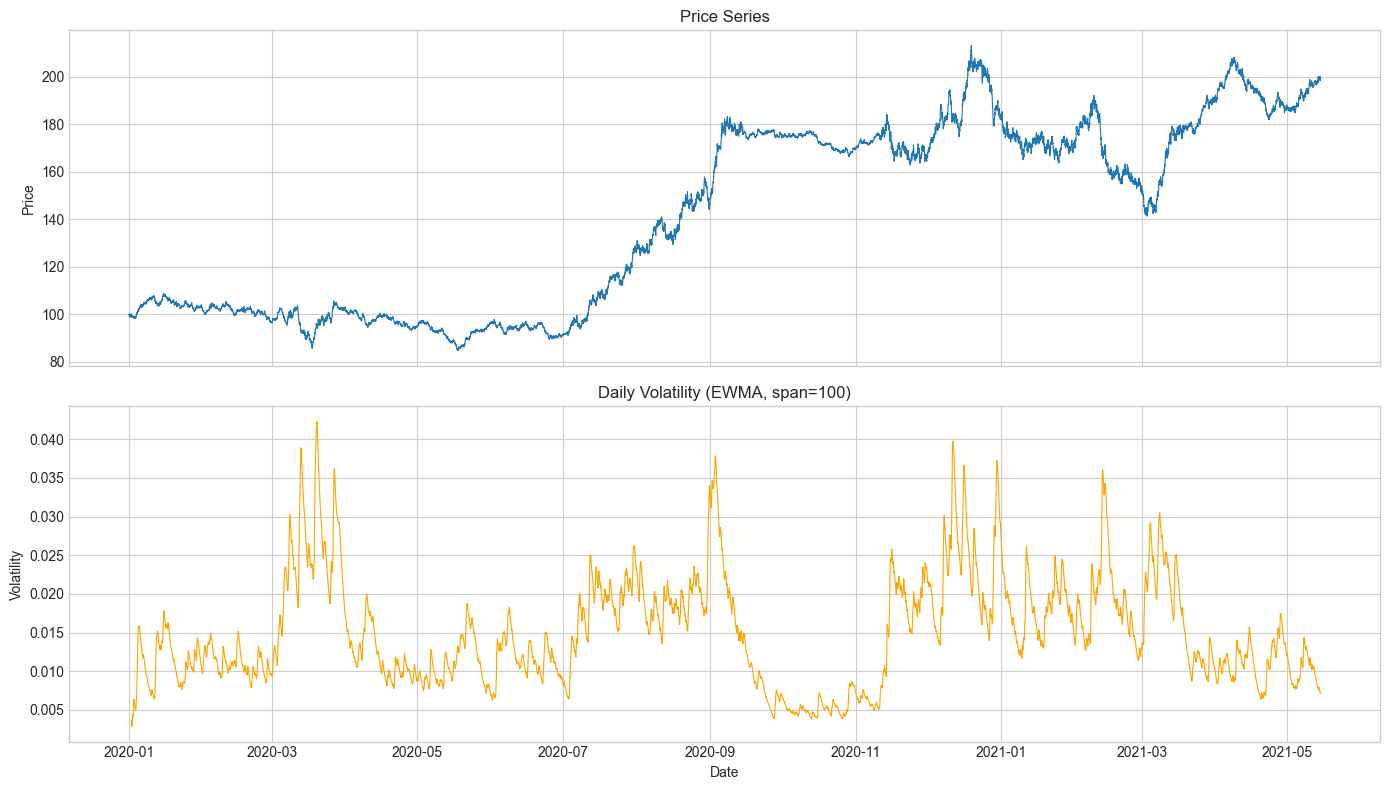

Volatility statistics:
  Mean: 0.0151
  Std:  0.0070
  Min:  0.0029
  Max:  0.0423


In [4]:
# Compute daily volatility
daily_vol = get_daily_volatility(close_prices, lookback_span=100)

# Visualize volatility over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Price
axes[0].plot(close_prices.index, close_prices.values, linewidth=0.8)
axes[0].set_title('Price Series', fontsize=12)
axes[0].set_ylabel('Price')

# Volatility
axes[1].plot(daily_vol.index, daily_vol.values, linewidth=0.8, color='orange')
axes[1].set_title('Daily Volatility (EWMA, span=100)', fontsize=12)
axes[1].set_ylabel('Volatility')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

print(f"Volatility statistics:")
print(f"  Mean: {daily_vol.mean():.4f}")
print(f"  Std:  {daily_vol.std():.4f}")
print(f"  Min:  {daily_vol.min():.4f}")
print(f"  Max:  {daily_vol.max():.4f}")

---

## 3. The Triple-Barrier Method

The **Triple-Barrier Method** is a path-dependent labeling approach that addresses the shortcomings of fixed-horizon labeling. It defines three barriers:

1. **Upper Horizontal Barrier** (Profit-Taking): Price reaches target profit
2. **Lower Horizontal Barrier** (Stop-Loss): Price hits maximum acceptable loss
3. **Vertical Barrier** (Expiration): Maximum holding period reached

The observation is labeled based on **which barrier is touched first**.

### Why This Matters

Every real investment strategy has:
- **Profit targets**: When to take gains
- **Stop-losses**: When to cut losses (self-imposed, risk department, or margin calls)
- **Holding periods**: Maximum time to hold a position

The triple-barrier method incorporates these real-world constraints into the labeling process.

Example 1: Price hits profit-taking barrier


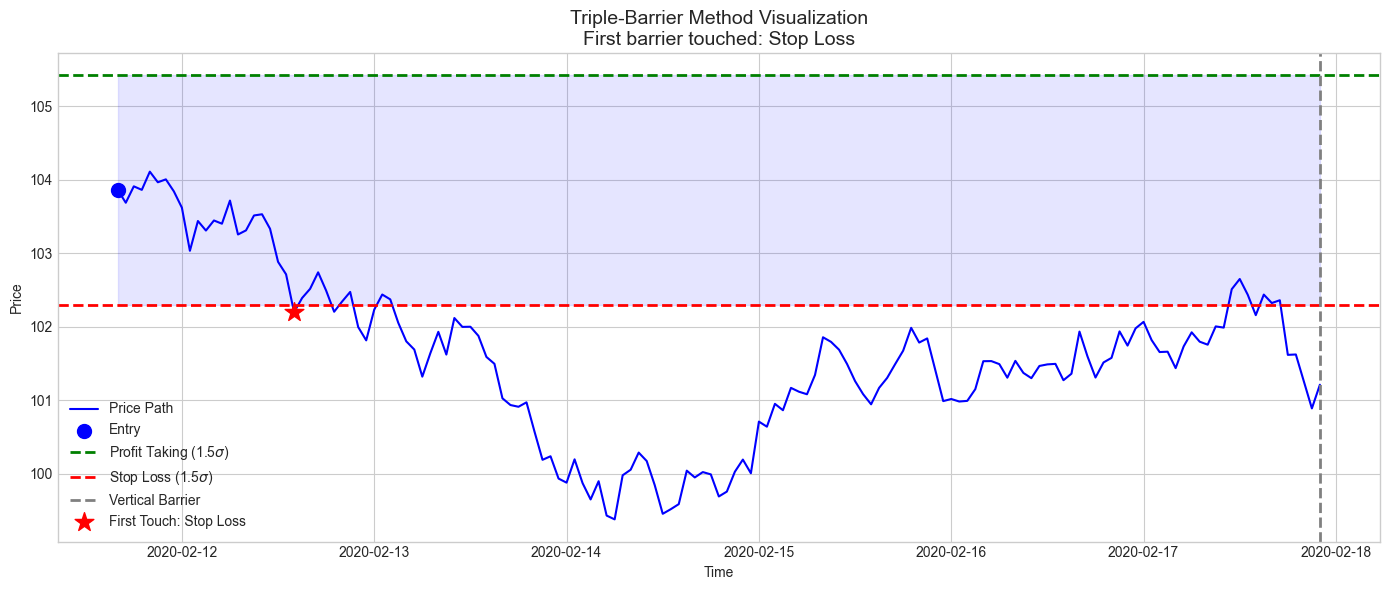


Example 2: Price hits stop-loss barrier


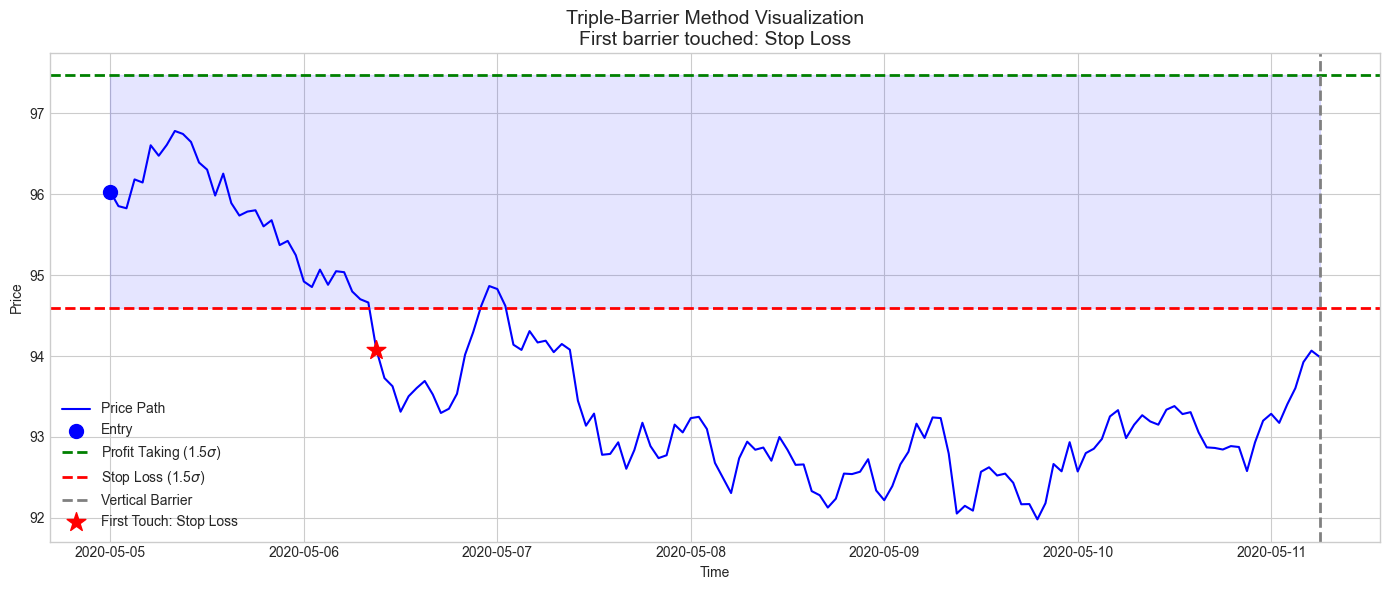


Example 3: Vertical barrier reached first


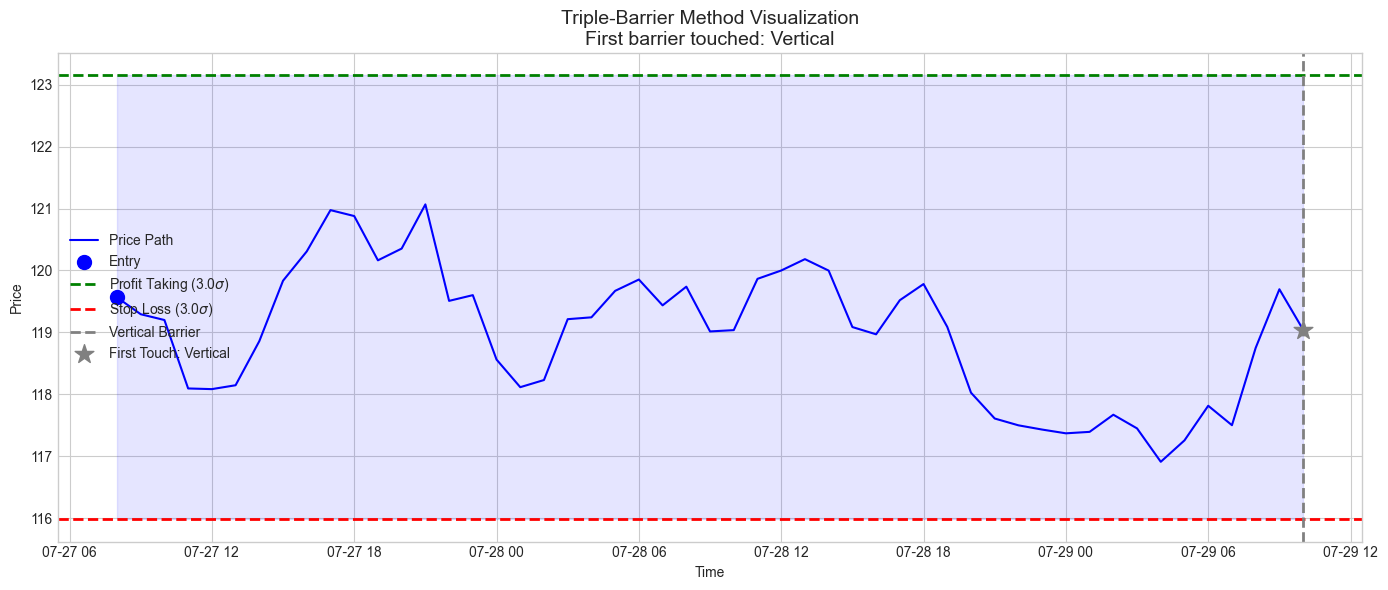

In [5]:
def visualize_triple_barrier(
    close: pd.Series,
    start_idx: int,
    vertical_bars: int = 100,
    pt_mult: float = 2.0,
    sl_mult: float = 2.0,
    volatility: float = None,
):
    """
    Visualize the triple-barrier method for a single event.
    """
    # Extract the relevant price path
    path = close.iloc[start_idx:start_idx + vertical_bars + 1]
    start_price = path.iloc[0]
    
    # Use provided volatility or estimate
    if volatility is None:
        volatility = close.pct_change().iloc[max(0, start_idx-100):start_idx].std()
    
    # Calculate barrier levels
    upper_barrier = start_price * (1 + pt_mult * volatility)
    lower_barrier = start_price * (1 - sl_mult * volatility)
    
    # Find which barrier is touched first
    returns = path / start_price - 1
    
    pt_touch = returns[returns > pt_mult * volatility].index.min()
    sl_touch = returns[returns < -sl_mult * volatility].index.min()
    vb_touch = path.index[-1]
    
    # Determine first touch
    touches = pd.Series({
        'Profit Taking': pt_touch,
        'Stop Loss': sl_touch,
        'Vertical': vb_touch,
    }).dropna().sort_values()
    
    first_barrier = touches.index[0]
    first_touch_time = touches.iloc[0]
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Price path
    ax.plot(path.index, path.values, 'b-', linewidth=1.5, label='Price Path')
    ax.scatter([path.index[0]], [start_price], color='blue', s=100, zorder=5, label='Entry')
    
    # Barriers
    ax.axhline(y=upper_barrier, color='green', linestyle='--', linewidth=2, 
               label=f'Profit Taking ({pt_mult}$\\sigma$)')
    ax.axhline(y=lower_barrier, color='red', linestyle='--', linewidth=2,
               label=f'Stop Loss ({sl_mult}$\\sigma$)')
    ax.axvline(x=path.index[-1], color='gray', linestyle='--', linewidth=2,
               label='Vertical Barrier')
    
    # Mark first touch
    touch_price = path.loc[first_touch_time]
    color = 'green' if first_barrier == 'Profit Taking' else 'red' if first_barrier == 'Stop Loss' else 'gray'
    ax.scatter([first_touch_time], [touch_price], color=color, s=200, marker='*', 
               zorder=5, label=f'First Touch: {first_barrier}')
    
    # Formatting
    ax.set_title(f'Triple-Barrier Method Visualization\nFirst barrier touched: {first_barrier}', 
                 fontsize=14)
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.legend(loc='best')
    ax.fill_between(path.index, lower_barrier, upper_barrier, alpha=0.1, color='blue')
    
    plt.tight_layout()
    plt.show()
    
    return first_barrier


# Visualize for different scenarios
print("Example 1: Price hits profit-taking barrier")
_ = visualize_triple_barrier(close_prices, start_idx=1000, vertical_bars=150, 
                             pt_mult=1.5, sl_mult=1.5, volatility=0.01)

print("\nExample 2: Price hits stop-loss barrier")
_ = visualize_triple_barrier(close_prices, start_idx=3000, vertical_bars=150,
                             pt_mult=1.5, sl_mult=1.5, volatility=0.01)

print("\nExample 3: Vertical barrier reached first")
_ = visualize_triple_barrier(close_prices, start_idx=5000, vertical_bars=50,
                             pt_mult=3.0, sl_mult=3.0, volatility=0.01)

### Barrier Configurations

The triple-barrier method supports various configurations denoted as `[pt, sl, t1]` where 1 means active and 0 means inactive:

| Config | Description | Use Case |
|--------|-------------|----------|
| `[1,1,1]` | All three barriers | Standard setup with profit target, stop-loss, and max holding period |
| `[0,1,1]` | No profit-taking | Exit after time or stop-loss; useful for hedging |
| `[1,1,0]` | No time limit | Hold until profit or stop-loss (less realistic) |
| `[0,0,1]` | Only vertical | Equivalent to fixed-time horizon |
| `[1,0,1]` | No stop-loss | Hold until profit or expiration (ignores losses) |

---

## 4. Learning Side and Size

When we **don't have a model to determine position direction** (long or short), we need to learn both:

1. **Side**: Should we go long (+1) or short (-1)?
2. **Size**: How much should we bet?

In this case, horizontal barriers must be **symmetric** because we can't distinguish between profit-taking and stop-loss without knowing the side.

### The Labeling Process

1. Sample events using techniques like CUSUM filter (Chapter 2)
2. Set symmetric barriers based on volatility
3. Find the first barrier touch
4. Label based on the return: `{-1, 0, 1}`

In [6]:
# Create sample events (in practice, use CUSUM filter)
# Here we'll sample every 24 hours for simplicity
sample_indices = close_prices.index[::24]
timestamp_events = pd.DatetimeIndex(sample_indices[:-10])  # Leave room for barriers

print(f"Number of events: {len(timestamp_events)}")
print(f"Event timestamps (first 5): {list(timestamp_events[:5])}")

Number of events: 490
Event timestamps (first 5): [Timestamp('2020-01-01 00:00:00'), Timestamp('2020-01-02 00:00:00'), Timestamp('2020-01-03 00:00:00'), Timestamp('2020-01-04 00:00:00'), Timestamp('2020-01-05 00:00:00')]


In [7]:
# Step 1: Compute target returns (daily volatility)
target_returns = get_daily_volatility(close_prices, lookback_span=50)

# Step 2: Add vertical barriers (e.g., 5 days max holding)
vertical_barriers = add_vertical_barrier(
    timestamp_events=timestamp_events,
    close_prices=close_prices,
    num_days=5,
)

print(f"Vertical barriers computed: {len(vertical_barriers)}")
print(f"\nSample vertical barriers:")
print(vertical_barriers.head())

Vertical barriers computed: 490

Sample vertical barriers:
2020-01-01   2020-01-06
2020-01-02   2020-01-07
2020-01-03   2020-01-08
2020-01-04   2020-01-09
2020-01-05   2020-01-10
Freq: 24h, dtype: datetime64[ns]


In [8]:
# Step 3: Get events with triple-barrier method
# Using symmetric barriers (pt_mult = sl_mult = 2)
events = get_events(
    close_prices=close_prices,
    timestamp_events=timestamp_events,
    profit_taking_stop_loss=[2.0, 2.0],  # Symmetric
    target_returns=target_returns,
    min_return=0.0001,  # Minimum volatility threshold
    num_threads=1,
    vertical_barrier_times=vertical_barriers,
    side=None,  # Learning side, so no side provided
)

print(f"Events DataFrame shape: {events.shape}")
print(f"\nEvents DataFrame columns: {list(events.columns)}")
print(f"\nSample events:")
events.head(10)

Events DataFrame shape: (488, 2)

Events DataFrame columns: ['t1', 'trgt']

Sample events:


,t1,trgt
2020-01-03,2020-01-04 04:00:00,0.006703
2020-01-04,2020-01-04 10:00:00,0.005590
2020-01-05,2020-01-07 07:00:00,0.015934
2020-01-06,2020-01-09 04:00:00,0.011060
2020-01-07,2020-01-08 10:00:00,0.010426
2020-01-08,2020-01-08 23:00:00,0.007926
2020-01-09,2020-01-09 15:00:00,0.006129
2020-01-10,2020-01-12 02:00:00,0.005365
2020-01-11,2020-01-11 23:00:00,0.005950
2020-01-12,2020-01-12 21:00:00,0.007709


In [9]:
# Step 4: Generate labels
labels = get_labels_side_and_size(events, close_prices)

print(f"Labels DataFrame shape: {labels.shape}")
print(f"\nLabel distribution:")
print(labels['bin'].value_counts().sort_index())
print(f"\nLabel percentages:")
print(labels['bin'].value_counts(normalize=True).sort_index())

Labels DataFrame shape: (488, 2)

Label distribution:
bin
-1.0    220
 1.0    268
Name: count, dtype: int64

Label percentages:
bin
-1.0    0.45082
 1.0    0.54918
Name: proportion, dtype: float64


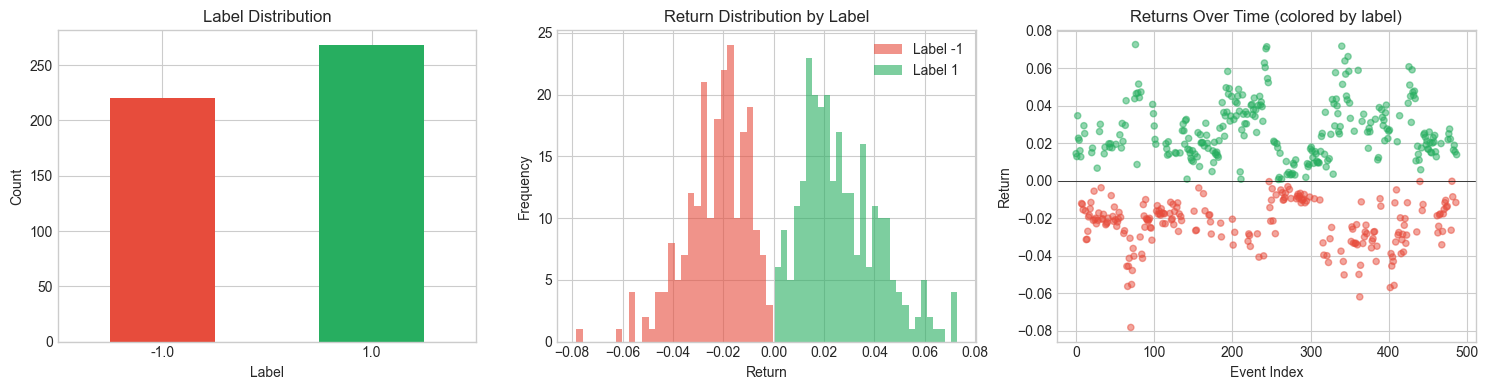

In [10]:
# Visualize label distribution and returns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Label distribution
label_dist = labels['bin'].value_counts().sort_index()
colors_dist = ['#e74c3c' if x == -1 else '#95a5a6' if x == 0 else '#27ae60' for x in label_dist.index]
label_dist.plot(kind='bar', ax=axes[0], color=colors_dist)
axes[0].set_title('Label Distribution', fontsize=12)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Return distribution by label
colors_map = {-1: '#e74c3c', 0: '#95a5a6', 1: '#27ae60'}
for label in sorted(labels['bin'].unique()):
    subset = labels[labels['bin'] == label]['ret']
    if len(subset) > 0:
        axes[1].hist(subset, bins=30, alpha=0.6, label=f'Label {int(label)}', color=colors_map.get(label, 'blue'))
axes[1].set_title('Return Distribution by Label', fontsize=12)
axes[1].set_xlabel('Return')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Returns over time
colors_mapped = [colors_map.get(x, 'blue') for x in labels['bin']]
axes[2].scatter(range(len(labels)), labels['ret'].values, c=colors_mapped, alpha=0.5, s=20)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_title('Returns Over Time (colored by label)', fontsize=12)
axes[2].set_xlabel('Event Index')
axes[2].set_ylabel('Return')

plt.tight_layout()
plt.show()

---

## 5. Meta-Labeling

**Meta-labeling** is one of the most powerful and often misunderstood concepts in the book. To truly understand it, we need to step back and think about what we're trying to accomplish.

### The Core Problem: Why Standard Labeling Falls Short

In standard labeling (Section 4), we train a single model to answer TWO questions at once:

1. **Direction**: Should we go long or short?
2. **Confidence**: Should we trade at all, and if so, how much?

This is asking a lot from one model. Consider a model that correctly predicts direction 60% of the time. That sounds good, but:
- When it's wrong, you lose money
- You don't know WHICH 60% it's right about
- All predictions are treated equally, regardless of confidence

### The Meta-Labeling Insight: Divide and Conquer

Meta-labeling separates these two questions into **two distinct stages**:

| Stage | Question | Model Type | Output |
|-------|----------|-----------|--------|
| **Stage 1** | "What direction?" | Primary Model (can be anything) | Side: {+1, -1} |
| **Stage 2** | "Should we act on this?" | Secondary ML Model | Bet: {0, 1} |

The key insight: **The secondary model doesn't predict direction—it predicts whether the primary model's prediction is correct.**

### Real-World Analogy: The Investment Committee

Think of it like an investment firm:

1. **Analyst Team (Primary Model)**: Researches opportunities and recommends "buy" or "sell" on specific stocks. They might use fundamental analysis, technical indicators, or any methodology.

2. **Risk Committee (Secondary Model)**: Reviews each recommendation and decides:
   - "Yes, we trust this call—execute the trade" (label = 1)
   - "No, something seems off—pass on this one" (label = 0)

The risk committee doesn't second-guess the direction. They're asking: "Given that the analyst says buy, should we actually do it?"

### Why This Works: The Precision/Recall Tradeoff

Consider the confusion matrix for a direction-prediction model:

```
                         ACTUAL MARKET MOVE
                      Profitable     Unprofitable
PRIMARY         Trade       TP              FP
PREDICTION    No Trade      FN              TN
```

A typical primary model optimized for recall might achieve:
- **High Recall**: Catches 80% of opportunities (few FN)
- **Low Precision**: Only 55% of its signals are correct (many FP)

The problem? Those false positives (FP) cost you money!

**The meta-labeling solution:**

1. **Primary model**: Optimizes for **RECALL** (catch most opportunities, even if many are wrong)
2. **Secondary model**: Filters out **FALSE POSITIVES** (improves precision)

The result: Better F1-score than either model alone could achieve.

### The Mathematical View

Let:
- $P$ = primary model's prediction (side: +1 for long, -1 for short)
- $R$ = actual return over the holding period
- $R_{adjusted} = R \times P$ = return adjusted for position side

The secondary model learns to predict:

$$
\text{Meta-Label} = \begin{cases}
1 & \text{if } R_{adjusted} > 0 \text{ (profitable trade)} \\
0 & \text{if } R_{adjusted} \leq 0 \text{ (unprofitable trade)}
\end{cases}
$$

In other words: **"Was the primary model's call correct?"**

**Concrete Example:**
- Primary model says: "Go LONG" (side = +1)
- Actual return: -2% (price went down)
- Adjusted return: -2% × +1 = -2%
- Meta-label: 0 (the long call was wrong, don't take this bet)

Another example:
- Primary model says: "Go SHORT" (side = -1)
- Actual return: -2% (price went down)
- Adjusted return: -2% × -1 = +2%
- Meta-label: 1 (the short call was correct, take this bet!)

### Asymmetric Barriers: A Key Advantage

Because we now KNOW the position side (from the primary model), we can set **asymmetric barriers**:

| Side | Profit-Taking Direction | Stop-Loss Direction |
|------|------------------------|---------------------|
| Long (+1) | Price goes UP | Price goes DOWN |
| Short (-1) | Price goes DOWN | Price goes UP |

Without knowing the side (standard labeling), we had to use symmetric barriers because we couldn't distinguish profit-taking from stop-loss. With meta-labeling, we can set:
- **Wider profit-taking**: Let winners run (e.g., 2× volatility)
- **Tighter stop-loss**: Cut losers quickly (e.g., 1× volatility)

This reflects how real trading strategies work—you typically want to give winning trades room to grow while cutting losses quickly.

### When to Use Meta-Labeling

Meta-labeling is particularly valuable when:

1. **You have a primary model you trust**: Perhaps a fundamental model based on domain expertise, or a simple rule-based system that makes economic sense.

2. **Your primary model has high recall but low precision**: It catches most opportunities but generates many false signals. Meta-labeling helps filter these.

3. **You want interpretability**: The primary model can remain a simple, explainable "white box" while the ML complexity is confined to the sizing decision.

4. **You need proper bet sizing**: The secondary model outputs a probability (not just 0/1), which can be used to size positions proportionally to confidence.

5. **You want to reduce overfitting**: By limiting the ML model to learning "when to act" rather than "what direction," you constrain the hypothesis space and reduce overfitting risk.

### Benefits Summary

| Benefit | Explanation |
|---------|-------------|
| **Improved F1-Score** | Filters out false positives from the primary model |
| **Interpretability** | Primary model can be a "white box" (fundamental model) |
| **Reduced Overfitting** | ML only learns sizing, not direction |
| **Strategy Flexibility** | Can use different models for long vs. short positions |
| **Proper Bet Sizing** | Model's probability output enables continuous position sizing |
| **Asymmetric Barriers** | Can set different profit-taking and stop-loss thresholds |

### The Meta-Labeling Workflow

```
┌─────────────────┐     ┌─────────────────┐     ┌─────────────────┐
│  Primary Model  │────▶│  Triple-Barrier │────▶│ Secondary Model │
│  (Any model)    │     │  with Side      │     │  (ML classifier) │
│                 │     │                 │     │                 │
│  Output: Side   │     │  Output: Events │     │  Output: P(bet) │
│  {+1, -1}       │     │  with meta-label│     │  [0, 1]         │
└─────────────────┘     └─────────────────┘     └─────────────────┘
         │                       │                       │
         │                       │                       ▼
         │                       │              Position Size = 
         │                       │              Side × P(bet) × Capital
         ▼                       ▼
    "Go long"            "Was it right?"        "Bet 30% of capital
     or short"           {0, 1}                  on a long position"
```

Now let's see this in action with a simple primary model.

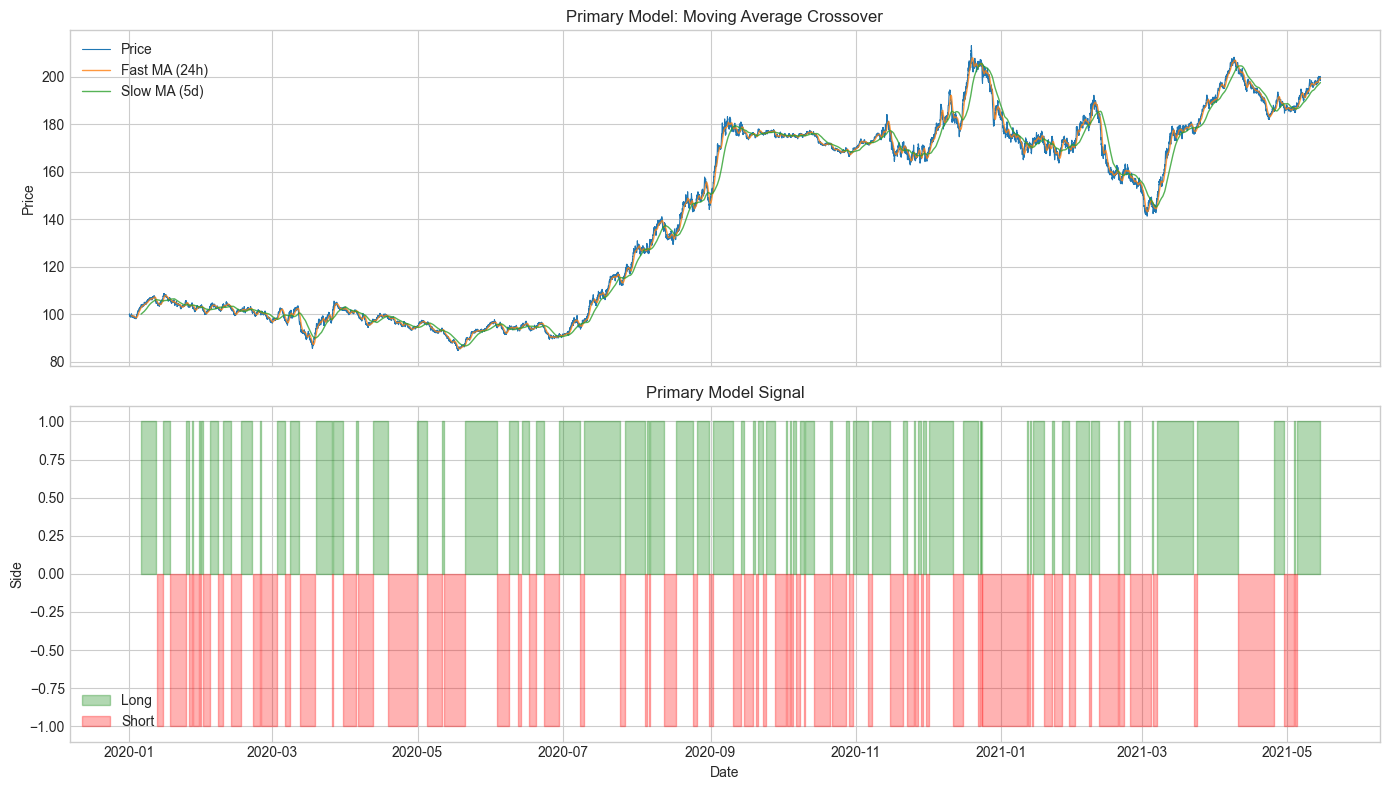

In [11]:
def simple_momentum_strategy(close: pd.Series, fast: int = 10, slow: int = 50) -> pd.Series:
    """
    Simple moving average crossover strategy.
    Returns +1 (long) when fast MA > slow MA, -1 (short) otherwise.
    
    This serves as our "primary model" for meta-labeling.
    """
    fast_ma = close.rolling(fast).mean()
    slow_ma = close.rolling(slow).mean()
    
    side = pd.Series(index=close.index, dtype=float)
    side[fast_ma > slow_ma] = 1.0
    side[fast_ma <= slow_ma] = -1.0
    
    return side


# Generate signals from primary model
primary_model_side = simple_momentum_strategy(close_prices, fast=24, slow=24*5)

# Visualize the primary model
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Price with MAs
axes[0].plot(close_prices.index, close_prices.values, linewidth=0.8, label='Price')
axes[0].plot(close_prices.index, close_prices.rolling(24).mean().values, 
             linewidth=1, label='Fast MA (24h)', alpha=0.8)
axes[0].plot(close_prices.index, close_prices.rolling(24*5).mean().values,
             linewidth=1, label='Slow MA (5d)', alpha=0.8)
axes[0].set_title('Primary Model: Moving Average Crossover', fontsize=12)
axes[0].set_ylabel('Price')
axes[0].legend()

# Signal
signal_clean = primary_model_side.dropna()
axes[1].fill_between(signal_clean.index, 0, signal_clean.values,
                     where=signal_clean > 0, color='green', alpha=0.3, label='Long')
axes[1].fill_between(signal_clean.index, 0, signal_clean.values,
                     where=signal_clean < 0, color='red', alpha=0.3, label='Short')
axes[1].set_title('Primary Model Signal', fontsize=12)
axes[1].set_ylabel('Side')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()

In [12]:
# Now apply meta-labeling
# The key difference: we provide the 'side' from our primary model

# Get the side for our event timestamps
side_at_events = primary_model_side.loc[
    primary_model_side.index.intersection(timestamp_events)
].dropna()

# Filter events to those where we have a side signal
valid_events = timestamp_events[timestamp_events.isin(side_at_events.index)]

print(f"Events with side signal: {len(valid_events)}")

Events with side signal: 485


In [13]:
# Get events with meta-labeling (providing side)
# Note: Now we can use ASYMMETRIC barriers since we know the side
meta_events = get_events(
    close_prices=close_prices,
    timestamp_events=valid_events,
    profit_taking_stop_loss=[2.0, 1.0],  # Asymmetric: wider profit target, tighter stop
    target_returns=target_returns,
    min_return=0.0001,
    num_threads=1,
    vertical_barrier_times=vertical_barriers,
    side=side_at_events,  # Providing side for meta-labeling
)

print(f"Meta-labeling events shape: {meta_events.shape}")
print(f"\nMeta-labeling events columns: {list(meta_events.columns)}")
meta_events.head()

Meta-labeling events shape: (485, 3)

Meta-labeling events columns: ['t1', 'trgt', 'side']


,t1,trgt,side
2020-01-06,2020-01-09 04:00:00,0.011060,1.0
2020-01-07,2020-01-08 10:00:00,0.010426,1.0
2020-01-08,2020-01-08 23:00:00,0.007926,1.0
2020-01-09,2020-01-09 15:00:00,0.006129,1.0
2020-01-10,2020-01-10 10:00:00,0.005365,1.0


In [14]:
# Generate meta-labels
meta_labels = get_labels(meta_events, close_prices)

print(f"Meta-labels shape: {meta_labels.shape}")
print(f"\nMeta-label distribution:")
print(meta_labels['bin'].value_counts().sort_index())
print(f"\nMeta-label percentages:")
print(meta_labels['bin'].value_counts(normalize=True).sort_index())

Meta-labels shape: (485, 2)

Meta-label distribution:
bin
0.0    296
1.0    189
Name: count, dtype: int64

Meta-label percentages:
bin
0.0    0.610309
1.0    0.389691
Name: proportion, dtype: float64


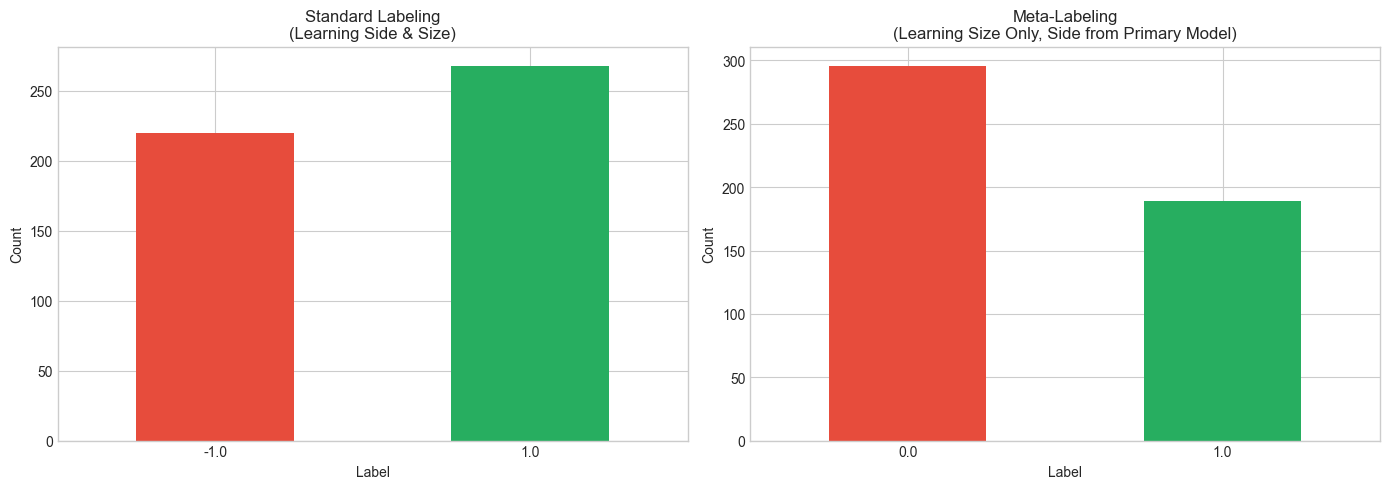


KEY INSIGHT

Meta-labeling transforms the problem from:
  - 3-class classification {-1, 0, 1} (direction + no trade)
  
To:
  - Binary classification {0, 1} (trade or don't trade)

The primary model provides the DIRECTION.
The secondary (meta) model decides WHETHER TO ACT.

This is particularly useful because:
1. You can use interpretable primary models (fundamental analysis)
2. The ML model focuses on filtering false positives
3. Overfitting is reduced (not learning direction)



In [15]:
# Compare standard labeling vs meta-labeling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard labeling
std_dist = labels['bin'].value_counts().sort_index()
std_colors = ['#e74c3c' if x == -1 else '#95a5a6' if x == 0 else '#27ae60' for x in std_dist.index]
std_dist.plot(kind='bar', ax=axes[0], color=std_colors)
axes[0].set_title('Standard Labeling\n(Learning Side & Size)', fontsize=12)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Meta-labeling
meta_dist = meta_labels['bin'].value_counts().sort_index()
meta_colors = ['#e74c3c' if x == 0 else '#27ae60' for x in meta_dist.index]
meta_dist.plot(kind='bar', ax=axes[1], color=meta_colors)
axes[1].set_title('Meta-Labeling\n(Learning Size Only, Side from Primary Model)', fontsize=12)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHT")
print("="*60)
print("""
Meta-labeling transforms the problem from:
  - 3-class classification {-1, 0, 1} (direction + no trade)
  
To:
  - Binary classification {0, 1} (trade or don't trade)

The primary model provides the DIRECTION.
The secondary (meta) model decides WHETHER TO ACT.

This is particularly useful because:
1. You can use interpretable primary models (fundamental analysis)
2. The ML model focuses on filtering false positives
3. Overfitting is reduced (not learning direction)
""")

### Understanding the Confusion Matrix in Meta-Labeling

Meta-labeling helps improve the **F1-score** by filtering false positives:

```
                    ACTUAL
                Positive  Negative
PREDICTED  Pos    TP        FP
           Neg    FN        TN
```

- **Precision** = TP / (TP + FP) - How many of our trades were profitable?
- **Recall** = TP / (TP + FN) - How many profitable opportunities did we capture?
- **F1-Score** = 2 x (Precision x Recall) / (Precision + Recall)

The meta-labeling approach:
1. Primary model aims for **high recall** (catch most opportunities)
2. Secondary model improves **precision** (filter bad ones)

---

## 6. Handling Imbalanced Labels

Class imbalance is a common problem in financial ML. Some labels may appear much more frequently than others, which can cause:

- Models that always predict the majority class
- Poor performance on minority classes
- Misleading accuracy metrics

### Solutions

1. **Drop rare labels** (simple but loses data)
2. **Undersample majority class** (preserves minority but loses data)
3. **Oversample minority class** (SMOTE, etc.)
4. **Class weights** in the ML algorithm
5. **Use appropriate metrics** (F1, AUC instead of accuracy)

In [16]:
# Import utility functions
from afml.labeling.utils import (
    drop_rare_labels,
    compute_label_statistics,
    balance_labels_by_undersampling,
)

# Check current label statistics
print("Current label statistics:")
print(compute_label_statistics(labels))

Current label statistics:
       count  percentage  cumulative_percentage
label                                          
-1.0     220     0.45082                0.45082
 1.0     268     0.54918                1.00000


In [17]:
# Create an artificially imbalanced dataset for demonstration
imbalanced_labels = labels.copy()

# Artificially make the '0' label very rare (if it exists)
zero_mask = imbalanced_labels['bin'] == 0
if zero_mask.sum() > 0:
    zero_indices = imbalanced_labels[zero_mask].index
    keep_ratio = 0.1  # Keep only 10% of zero labels
    n_keep = max(1, int(len(zero_indices) * keep_ratio))
    drop_indices = zero_indices[n_keep:]
    imbalanced_labels = imbalanced_labels.drop(drop_indices)

print("Imbalanced label distribution:")
print(compute_label_statistics(imbalanced_labels))

Imbalanced label distribution:
       count  percentage  cumulative_percentage
label                                          
-1.0     220     0.45082                0.45082
 1.0     268     0.54918                1.00000


In [18]:
# Method 1: Drop rare labels
balanced_dropped = drop_rare_labels(
    imbalanced_labels, 
    min_percentage=0.05,  # Drop labels with < 5% frequency
    verbose=True
)

print(f"\nAfter dropping rare labels:")
print(f"Original size: {len(imbalanced_labels)}")
print(f"New size: {len(balanced_dropped)}")
print(f"\nNew distribution:")
print(balanced_dropped['bin'].value_counts(normalize=True).sort_index())


After dropping rare labels:
Original size: 488
New size: 488

New distribution:
bin
-1.0    0.45082
 1.0    0.54918
Name: proportion, dtype: float64


In [19]:
# Method 2: Undersample majority classes
balanced_undersampled = balance_labels_by_undersampling(
    imbalanced_labels,
    random_state=42
)

print(f"After undersampling:")
print(f"Original size: {len(imbalanced_labels)}")
print(f"New size: {len(balanced_undersampled)}")
print(f"\nNew distribution:")
print(balanced_undersampled['bin'].value_counts(normalize=True).sort_index())

After undersampling:
Original size: 488
New size: 440

New distribution:
bin
-1.0    0.5
 1.0    0.5
Name: proportion, dtype: float64


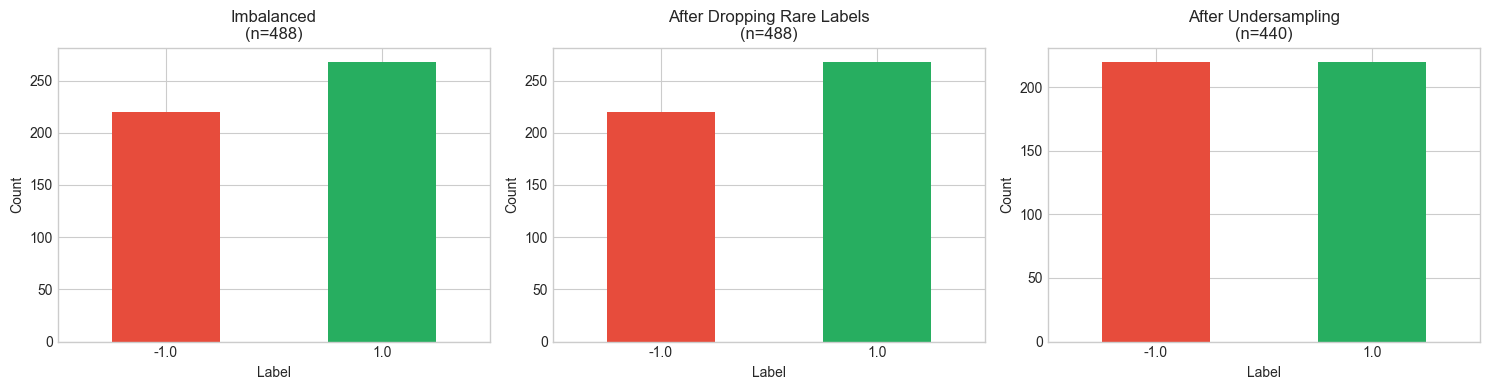

In [20]:
# Visualize the different approaches
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original imbalanced
imb_dist = imbalanced_labels['bin'].value_counts().sort_index()
imb_colors = ['#e74c3c' if x == -1 else '#95a5a6' if x == 0 else '#27ae60' for x in imb_dist.index]
imb_dist.plot(kind='bar', ax=axes[0], color=imb_colors)
axes[0].set_title(f'Imbalanced\n(n={len(imbalanced_labels)})', fontsize=12)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# After dropping rare labels
drop_dist = balanced_dropped['bin'].value_counts().sort_index()
drop_colors = ['#e74c3c' if x == -1 else '#95a5a6' if x == 0 else '#27ae60' for x in drop_dist.index]
drop_dist.plot(kind='bar', ax=axes[1], color=drop_colors)
axes[1].set_title(f'After Dropping Rare Labels\n(n={len(balanced_dropped)})', fontsize=12)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

# After undersampling
under_dist = balanced_undersampled['bin'].value_counts().sort_index()
under_colors = ['#e74c3c' if x == -1 else '#95a5a6' if x == 0 else '#27ae60' for x in under_dist.index]
under_dist.plot(kind='bar', ax=axes[2], color=under_colors)
axes[2].set_title(f'After Undersampling\n(n={len(balanced_undersampled)})', fontsize=12)
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

---

## Summary

### Key Takeaways

1. **Avoid fixed-time horizon labeling**: It ignores volatility regimes and price paths

2. **Use dynamic thresholds**: Adapt profit-taking and stop-loss levels to current volatility

3. **Triple-barrier method**: A realistic, path-dependent labeling approach that incorporates:
   - Profit-taking targets
   - Stop-loss limits
   - Maximum holding periods

4. **Meta-labeling**: A powerful two-stage approach where:
   - Primary model determines trade direction
   - Secondary model decides whether to act and how much to bet

5. **Handle class imbalance**: Use appropriate techniques to ensure your model learns from all classes

### Function Reference

| Function | Purpose |
|----------|----------|
| `get_daily_volatility()` | Compute dynamic volatility for threshold setting |
| `add_vertical_barrier()` | Set maximum holding period barriers |
| `get_events()` | Apply triple-barrier method to find first barrier touches |
| `get_labels()` | Generate labels with meta-labeling support |
| `get_labels_side_and_size()` | Generate labels when learning both side and size |
| `drop_rare_labels()` | Remove observations with rare labels |

---

## Exercises

1. **Experiment with barrier configurations**: Try different `[pt, sl, t1]` configurations and observe how label distributions change.

2. **Test different volatility spans**: How does changing `lookback_span` in `get_daily_volatility()` affect your labels?

3. **Build a meta-labeling pipeline**: Use a different primary model (e.g., RSI, Bollinger Bands) and apply meta-labeling.

4. **Compare labeling methods**: Generate labels using both fixed-horizon and triple-barrier methods on the same data. Train a simple classifier on each and compare performance.